<a href="https://colab.research.google.com/github/deepwindlee/MySQL-with-Python-DATA-MINING/blob/master/Multiple_Time_Series_Using_Apache_Spark_and_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 安装Java环境

---




In [6]:
!apt-get install -y openjdk-8-jdk-headless -qq >/dev/null

https://www.youtube.com/watch?v=AO8pCAQ0sPw
   
   
   https://github.com/srivatsan88/Mastering-Apache-Spark

   https://github.com/srivatsan88/End-to-End-Time-Series/blob/master/Multiple_Time_Series_using_Apache_Spark_and_Prophet.ipynb

In [7]:
pwd

'/content'

In [8]:
import os
os.environ['JAVA_HOME'] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [9]:
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode


In [10]:
!java -version

openjdk version "1.8.0_275"
OpenJDK Runtime Environment (build 1.8.0_275-8u275-b01-0ubuntu1~18.04-b01)
OpenJDK 64-Bit Server VM (build 25.275-b01, mixed mode)


# 安装pyspark  fbprophet



In [11]:
!pip install pyspark

     |████████████████████████████████| 204.2MB 53kB/s 
     |████████████████████████████████| 204kB 35.1MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612243 sha256=4f6903997800f90f5c3e77ca5a7d43da09a04b2c709ca082962cba5c0dd4bc22
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


In [12]:
!pip install pyarrow==0.15.1

     |████████████████████████████████| 59.2MB 65kB/s 
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1


In [13]:
!pip install fbprophet

# 读取数据



In [14]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from fbprophet import Prophet
mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [15]:
from pyspark.sql import SparkSession
import pyspark
spark = SparkSession.builder.master('local').getOrCreate()

In [16]:
df = pd.read_csv('https://raw.githubusercontent.com/srivatsan88/YouTubeLI/master/dataset/weekly_sales_data.csv')
df

,date,store_id,sales
0,1/6/2019,25,736657.2267
1,1/6/2019,26,233711.0000
2,1/6/2019,28,692156.3794
3,1/6/2019,29,213706.8000
4,1/6/2019,30,266455.0000
...,...,...,...
495,12/15/2019,31,401803.3590
496,12/15/2019,35,135799.1429
497,12/15/2019,38,115424.2250
498,12/15/2019,41,103375.0000


In [ ]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

# 探索数据


In [17]:
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values :  ", df.isnull().any())
print ("\nUnique values :  \n",df.nunique())


Features : 
 ['date', 'store_id', 'sales']

Missing values :   date        False
store_id    False
sales       False
dtype: bool

Unique values :  
 date         50
store_id     10
sales       500
dtype: int64


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      500 non-null    object 
 1   store_id  500 non-null    int64  
 2   sales     500 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 11.8+ KB


In [21]:
df_base = df.copy()
df.describe()

,store_id,sales
count,500.0000,5.000000e+02
mean,32.7000,4.470800e+05
std,6.1714,2.970660e+05
min,25.0000,1.278800e+04
25%,28.0000,2.526557e+05
50%,30.5000,3.150259e+05
75%,38.0000,6.845418e+05
max,44.0000,1.631585e+06


In [22]:
item_df = df.set_index('date')

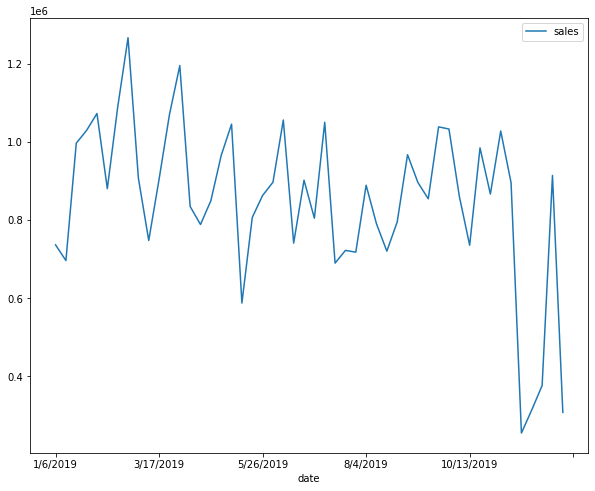

In [24]:
item_df.query("store_id==25")[['sales']].plot()

# 创建 spark dataframe

In [26]:
sdf = spark.createDataFrame(df)

In [27]:
sdf.printSchema()

root
 |-- date: string (nullable = true)
 |-- store_id: long (nullable = true)
 |-- sales: double (nullable = true)



In [28]:
sdf.select(['store_id']).groupBy('store_id').agg({'store_id':'count'}).show()

+--------+---------------+
|store_id|count(store_id)|
+--------+---------------+
|      26|             50|
|      29|             50|
|      31|             50|
|      25|             50|
|      41|             50|
|      28|             50|
|      44|             50|
|      35|             50|
|      38|             50|
|      30|             50|
+--------+---------------+



In [34]:
sdf.createOrReplaceTempView("sales")

In [36]:
spark.sql("select store_id, count(*) from sales group by store_id order by store_id").show()

+--------+--------+
|store_id|count(1)|
+--------+--------+
|      25|      50|
|      26|      50|
|      28|      50|
|      29|      50|
|      30|      50|
|      31|      50|
|      35|      50|
|      38|      50|
|      41|      50|
|      44|      50|
+--------+--------+



In [37]:
sql = 'SELECT store_id, date as ds, sum(sales) as y FROM sales GROUP BY store_id, ds ORDER BY store_id, ds'

In [38]:
spark.sql(sql).show()

+--------+----------+------------------+
|store_id|        ds|                 y|
+--------+----------+------------------+
|      25| 1/13/2019|       696457.1717|
|      25| 1/20/2019|        996876.875|
|      25| 1/27/2019|        1029737.05|
|      25|  1/6/2019|       736657.2267|
|      25|10/13/2019|        735723.327|
|      25|10/20/2019|         984872.55|
|      25|10/27/2019|       866777.1362|
|      25| 10/6/2019|          861162.1|
|      25|11/10/2019|         895675.95|
|      25|11/17/2019|       255034.3333|
|      25|11/24/2019|          314210.5|
|      25| 11/3/2019|1028016.8470000001|
|      25| 12/1/2019|       376708.0633|
|      25|12/15/2019|       307857.8817|
|      25| 12/8/2019|       914292.7833|
|      25| 2/10/2019|       880462.4681|
|      25| 2/17/2019|        1088756.78|
|      25| 2/24/2019|       1266928.313|
|      25|  2/3/2019|       1072873.705|
|      25| 3/10/2019|       747920.9824|
+--------+----------+------------------+
only showing top

In [39]:
sdf.explain()

== Physical Plan ==
*(1) Scan ExistingRDD[date#6,store_id#7L,sales#8]




In [40]:
sdf.rdd.getNumPartitions()

1

In [44]:
store_part = (spark.sql( sql ).repartition(spark.sparkContext.defaultParallelism, ['store_id'])).cache()

In [45]:
store_part

DataFrame[store_id: bigint, ds: string, y: double]

In [46]:
store_part.explain()

== Physical Plan ==
InMemoryTableScan [store_id#7L, ds#125, y#126]
   +- InMemoryRelation [store_id#7L, ds#125, y#126], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Exchange hashpartitioning(store_id#7L, 1), false, [id=#146]
            +- *(3) Sort [store_id#7L ASC NULLS FIRST, ds#90 ASC NULLS FIRST], true, 0
               +- Exchange rangepartitioning(store_id#7L ASC NULLS FIRST, ds#90 ASC NULLS FIRST, 200), true, [id=#142]
                  +- *(2) HashAggregate(keys=[store_id#7L, date#6], functions=[sum(sales#8)])
                     +- Exchange hashpartitioning(store_id#7L, date#6, 200), true, [id=#138]
                        +- *(1) HashAggregate(keys=[store_id#7L, date#6], functions=[partial_sum(sales#8)])
                           +- *(1) Scan ExistingRDD[date#6,store_id#7L,sales#8]




In [47]:
from pyspark.sql.types import *
result_schema =StructType([
  StructField('ds',TimestampType()),
  StructField('store_id',IntegerType()),
  StructField('y',DoubleType()),
  StructField('yhat',DoubleType()),
  StructField('yhat_upper',DoubleType()),
  StructField('yhat_lower',DoubleType())
  ])

In [48]:
from pyspark.sql.functions import pandas_udf, PandasUDFType

@pandas_udf( result_schema, PandasUDFType.GROUPED_MAP )
def forecast_sales( store_pd ):

  model = Prophet(interval_width=0.95,seasonality_mode = 'multiplicative', weekly_seasonality=True, yearly_seasonality=True)

  model.fit( store_pd )

  future_pd = model.make_future_dataframe(
    periods=5, 
    freq='w'
    )
  
  forecast_pd = model.predict( future_pd )  
  
  f_pd = forecast_pd[ ['ds','yhat', 'yhat_upper', 'yhat_lower'] ].set_index('ds')
  
  st_pd = store_pd[['ds','store_id','y']].set_index('ds')
  
  results_pd = f_pd.join( st_pd, how='left' )
  results_pd.reset_index(level=0, inplace=True)
  
  results_pd['store_id'] = store_pd['store_id'].iloc[0]

  return results_pd[ ['ds', 'store_id','y', 'yhat', 'yhat_upper', 'yhat_lower'] ]


In [49]:
from pyspark.sql.functions import current_date

results = (
  store_part
    .groupBy('store_id')
    .apply(forecast_sales)
    .withColumn('training_date', current_date() )
    )

/usr/local/lib/python3.6/dist-packages/pyspark/sql/pandas/group_ops.py:76: UserWarning:

It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.



In [64]:
results

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [51]:

results.show()

+-------------------+--------+------------------+------------------+------------------+-----------------+-------------+
|                 ds|store_id|                 y|              yhat|        yhat_upper|       yhat_lower|training_date|
+-------------------+--------+------------------+------------------+------------------+-----------------+-------------+
|2019-01-06 00:00:00|      25|       736657.2267| 712575.0694095818|  951140.578583313| 480838.477895834|   2020-11-27|
|2019-01-13 00:00:00|      25|       696457.1717| 743751.7568979745| 982175.3551027562|523125.4167708676|   2020-11-27|
|2019-01-20 00:00:00|      25|        996876.875| 972909.8778074606|1192642.6419723546|736619.2319320181|   2020-11-27|
|2019-01-27 00:00:00|      25|        1029737.05|1034447.5557655566| 1274185.687448265|814257.1160012698|   2020-11-27|
|2019-02-03 00:00:00|      25|       1072873.705| 986365.7266813249|1238918.2283004974|741233.3078016025|   2020-11-27|
|2019-02-10 00:00:00|      25|       880

In [52]:
results.explain()

== Physical Plan ==
*(2) Project [ds#182, store_id#183, y#184, yhat#185, yhat_upper#186, yhat_lower#187, 18593 AS training_date#194]
+- FlatMapGroupsInPandas [store_id#7L], forecast_sales(store_id#7L, ds#125, y#126), [ds#182, store_id#183, y#184, yhat#185, yhat_upper#186, yhat_lower#187]
   +- *(1) Sort [store_id#7L ASC NULLS FIRST], false, 0
      +- InMemoryTableScan [store_id#7L, store_id#7L, ds#125, y#126]
            +- InMemoryRelation [store_id#7L, ds#125, y#126], StorageLevel(disk, memory, deserialized, 1 replicas)
                  +- Exchange hashpartitioning(store_id#7L, 1), false, [id=#146]
                     +- *(3) Sort [store_id#7L ASC NULLS FIRST, ds#90 ASC NULLS FIRST], true, 0
                        +- Exchange rangepartitioning(store_id#7L ASC NULLS FIRST, ds#90 ASC NULLS FIRST, 200), true, [id=#142]
                           +- *(2) HashAggregate(keys=[store_id#7L, date#6], functions=[sum(sales#8)])
                              +- Exchange hashpartitioning(stor

In [53]:
results.coalesce(1)

DataFrame[ds: timestamp, store_id: int, y: double, yhat: double, yhat_upper: double, yhat_lower: double, training_date: date]

In [54]:
results.count()

550

In [61]:
results.createOrReplaceTempView('forecasted')

In [62]:
spark.sql("select store_id, count(*) from forecasted group by store_id").show()

+--------+--------+
|store_id|count(1)|
+--------+--------+
|      31|      55|
|      28|      55|
|      26|      55|
|      44|      55|
|      41|      55|
|      35|      55|
|      38|      55|
|      25|      55|
|      29|      55|
|      30|      55|
+--------+--------+



In [65]:
final_df = results.toPandas()

In [66]:
final_df

,ds,store_id,y,yhat,yhat_upper,yhat_lower,training_date
0,2019-01-06,25,7.366572e+05,7.125751e+05,9.511406e+05,480838.477896,2020-11-27
1,2019-01-13,25,6.964572e+05,7.437518e+05,9.821754e+05,523125.416771,2020-11-27
2,2019-01-20,25,9.968769e+05,9.729099e+05,1.192643e+06,736619.231932,2020-11-27
3,2019-01-27,25,1.029737e+06,1.034448e+06,1.274186e+06,814257.116001,2020-11-27
4,2019-02-03,25,1.072874e+06,9.863657e+05,1.238918e+06,741233.307802,2020-11-27
...,...,...,...,...,...,...,...
545,2019-12-22,44,NaN,6.265474e+04,1.256189e+05,-1622.115614,2020-11-27
546,2019-12-29,44,NaN,2.657442e+04,9.146077e+04,-33624.394331,2020-11-27
547,2020-01-05,44,NaN,8.801264e+03,7.500485e+04,-53323.971125,2020-11-27
548,2020-01-12,44,NaN,4.665900e+03,7.162263e+04,-55275.376013,2020-11-27


In [69]:
final_df=final_df.set_index('ds')

SyntaxError: ignored

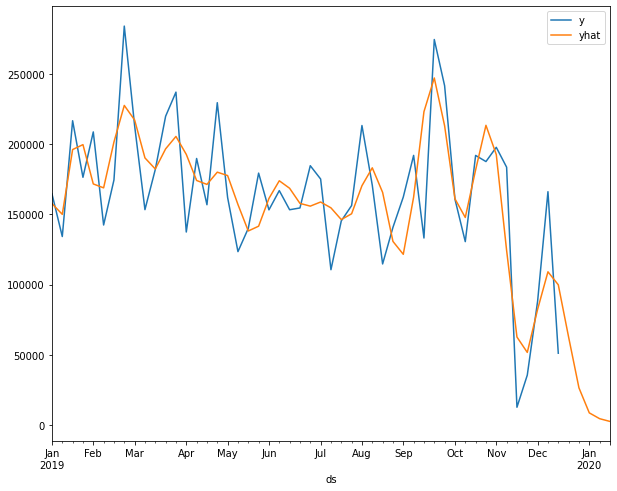

In [70]:
final_df.query('store_id==44')[['y','yhat']].plot()

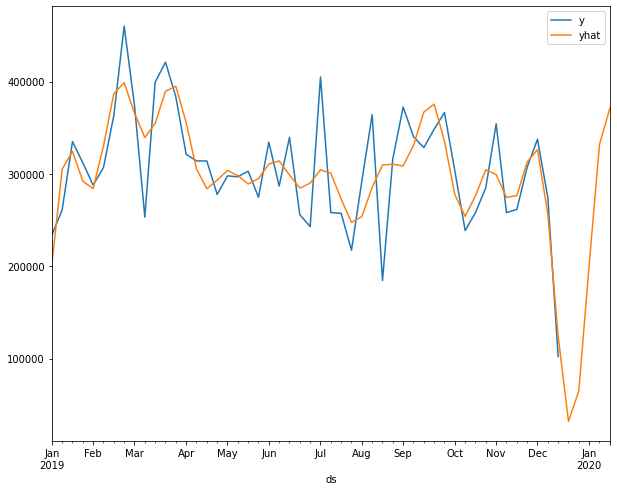

In [71]:
final_df.query('store_id==26')[['y','yhat']].plot()